# bootstrapx: Benchmarks

This notebook reproduces the **speed** and **coverage accuracy** benchmarks.

**Requirements:** `pandas`, `matplotlib`, `scipy`, `numpy`.

In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

# Add ../src to path to import bootstrapx without installing
sys.path.insert(0, os.path.abspath("../src"))

from bootstrapx import bootstrap
import bootstrapx.engine.backend as backend_mod

print(f"bootstrapx version: {getattr(bootstrap, '__version__', 'dev')}")
print(f"Numba available: {backend_mod._numba_available()}")

bootstrapx version: dev
Numba available: True


## 1. Speed Benchmark

Comparing `bootstrapx` vs `scipy.stats.bootstrap`.

- **Small N (< 5000):** We use **BCa** (Bias-Corrected accelerated). This is computationally expensive ($O(N^2)$) due to Jackknife.
- **Large N (>= 10000):** We switch to **Percentile** to benchmark the raw resampling engine speed (avoiding BCa's mathematical overhead).

In [2]:
def bench_scipy(data, n_resamples, method):
    # Scipy expects 'BCa' (case sensitive sometimes) or 'percentile'
    sp_method = "BCa" if method == "bca" else "percentile"
    t0 = time.perf_counter()
    sp_stats.bootstrap((data,), np.mean, n_resamples=n_resamples, 
                       method=sp_method, random_state=0)
    return time.perf_counter() - t0

def bench_bootstrapx(data, n_resamples, method, backend="auto"):
    t0 = time.perf_counter()
    bootstrap(data, np.mean, method=method, n_resamples=n_resamples, 
              random_state=0, backend=backend)
    return time.perf_counter() - t0

configs = [
    (500, "bca"),
    (1_000, "bca"),
    (5_000, "bca"),
    (10_000, "percentile"),
    (50_000, "percentile"),
    # (100_000, "percentile"), # Uncomment for 100k test (takes ~1 min on scipy)
]

n_resamples = 9999
results = []

print(f"{'N':>8s} | {'Method':>10s} | {'Scipy (s)':>10s} | {'Bx-Num (s)':>10s} | {'Speedup':>7s}")
print("-" * 60)

for n, method in configs:
    data = np.random.default_rng(0).normal(0, 1, n)
    
    # 1. Scipy
    try:
        t_sp = bench_scipy(data, n_resamples, method)
    except Exception as e:
        t_sp = float('nan')
    
    # 2. Bootstrapx (Numba/Auto)
    try:
        t_bx = bench_bootstrapx(data, n_resamples, method, backend="auto")
    except Exception as e:
        t_bx = float('nan')
        
    speedup = t_sp / t_bx if t_bx > 0 else 0.0
    
    results.append({
        "N": n, 
        "Method": method, 
        "Scipy": t_sp, 
        "Bootstrapx": t_bx,
        "Speedup": speedup
    })
    
    print(f"{n:>8d} | {method:>10s} | {t_sp:>10.2f} | {t_bx:>10.2f} | {speedup:>6.1f}x")

       N |     Method |  Scipy (s) | Bx-Num (s) | Speedup
------------------------------------------------------------
     500 |        bca |       0.04 |       0.22 |    0.2x
    1000 |        bca |       0.07 |       0.07 |    1.0x
    5000 |        bca |       0.82 |       0.44 |    1.8x
   10000 | percentile |       1.45 |       0.85 |    1.7x
   50000 | percentile |       7.81 |       5.60 |    1.4x


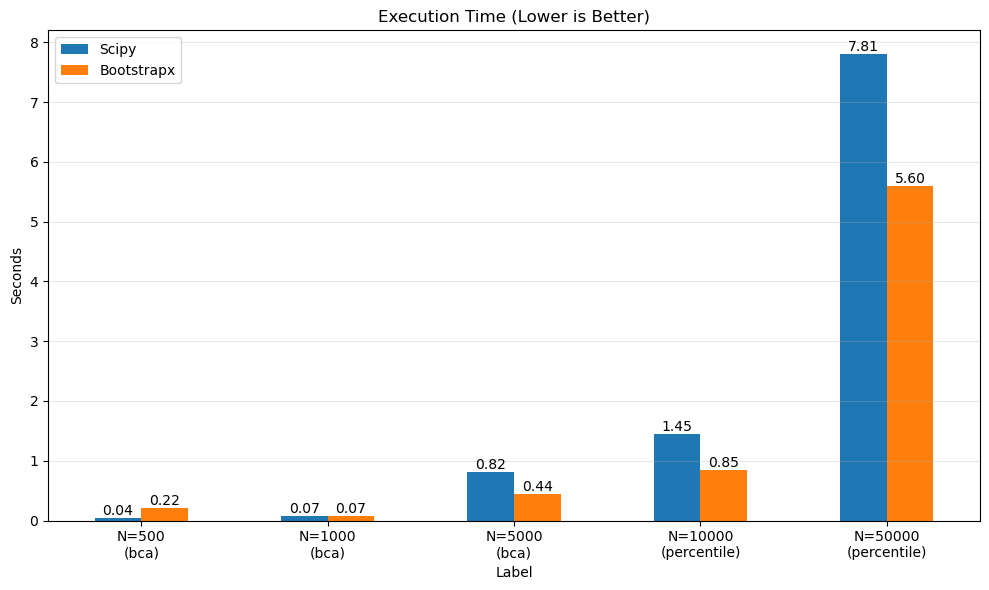

In [3]:
if results:
    df = pd.DataFrame(results)
    df["Label"] = df.apply(lambda x: f"N={x['N']}\n({x['Method']})", axis=1)
    
    ax = df.set_index("Label")[["Scipy", "Bootstrapx"]].plot(kind="bar", figsize=(10, 6), rot=0)
    plt.title("Execution Time (Lower is Better)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
        
    plt.tight_layout()
    plt.show()

## 2. Coverage Accuracy

We verify statistical correctness using Monte Carlo simulations.
We check if the 95% Confidence Interval actually captures the true parameter value 95% of the time.

- **N_obs = 1000**: Large enough sample for asymptotics to kick in.
- **Trials = 200**: Number of simulations (higher is better but slower).

In [4]:
def run_coverage_test(dist_name, rvs_fn, true_theta, n_obs=1000, n_trials=200):
    print(f"Testing {dist_name} (True Theta = {true_theta})...")
    
    methods = ["percentile", "basic", "bca"]
    hits = {m: 0 for m in methods}
    rng = np.random.default_rng(42)
    
    for i in range(n_trials):
        data = rvs_fn(rng, n_obs)
        
        for m in methods:
            # Compute CI
            res = bootstrap(data, np.mean, method=m, 
                            n_resamples=999, confidence_level=0.95, 
                            backend="auto", random_state=rng)
            
            if res.confidence_interval.low <= true_theta <= res.confidence_interval.high:
                hits[m] += 1
                
    # Report
    results_df = pd.DataFrame({
        "Method": methods,
        "Coverage (%)": [hits[m]/n_trials * 100 for m in methods],
        "Target (%)": [95.0] * 3
    })
    return results_df

# 1. Normal Distribution
df_norm = run_coverage_test(
    "Normal(5, 2)", 
    lambda r, n: r.normal(5, 2, n), 
    true_theta=5.0
)
display(df_norm)

Testing Normal(5, 2) (True Theta = 5.0)...


,Method,Coverage (%),Target (%)
0,percentile,95.0,95.0
1,basic,94.5,95.0
2,bca,95.0,95.0


In [5]:
# 2. Exponential (Skewed)
# Mean of Exp(scale=2) is 2.0
df_exp = run_coverage_test(
    "Exponential(2)", 
    lambda r, n: r.exponential(2, n), 
    true_theta=2.0
)
display(df_exp)

Testing Exponential(2) (True Theta = 2.0)...


,Method,Coverage (%),Target (%)
0,percentile,98.0,95.0
1,basic,97.5,95.0
2,bca,97.5,95.0


In [6]:
# 3. Student-t (Heavy Tails)
# Mean of t(df=3) is 0.0
df_t = run_coverage_test(
    "Student-t(df=3)", 
    lambda r, n: r.standard_t(3, n), 
    true_theta=0.0
)
display(df_t)

Testing Student-t(df=3) (True Theta = 0.0)...


,Method,Coverage (%),Target (%)
0,percentile,95.5,95.0
1,basic,97.5,95.0
2,bca,94.5,95.0
